In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [104]:
energy = pd.read_csv('../data/ile_de_france_dataset.csv',
               index_col=['date'], parse_dates=['date']).sort_values(by=['date'])

In [3]:
energy.head()

,Unnamed: 0,Région,Consommation (MW)
date,,,
2017-01-01 00:00:00,385520,Ile-de-France,24147.0
2017-01-01 01:00:00,385521,Ile-de-France,23337.0
2017-01-01 02:00:00,385522,Ile-de-France,22179.0
2017-01-01 03:00:00,385523,Ile-de-France,21433.0
2017-01-01 04:00:00,385524,Ile-de-France,20597.0


In [4]:
energy= energy.rename(columns={"Consommation (MW)": "consommation"})

In [5]:
energy=energy.drop(columns=['Unnamed: 0','Région'])

In [6]:
energy.dtypes

consommation    float64
dtype: object

In [7]:
energy.consommation = energy.consommation.astype(int)

In [8]:
energy.dtypes

consommation    int64
dtype: object

In [9]:
energy_train = energy['2018-11-01 00:00:00':'2018-12-31 23:00:00']

In [10]:
energy_test =  energy['2019-01-01 00:00:00':'2019-01-14 23:00:00']

In [11]:
energy_train.tail()

,consommation
date,
2018-12-31 19:00:00,20763
2018-12-31 20:00:00,20236
2018-12-31 21:00:00,18923
2018-12-31 22:00:00,17614
2018-12-31 23:00:00,18173


In [12]:
energy_train.tail()

,consommation
date,
2018-12-31 19:00:00,20763
2018-12-31 20:00:00,20236
2018-12-31 21:00:00,18923
2018-12-31 22:00:00,17614
2018-12-31 23:00:00,18173


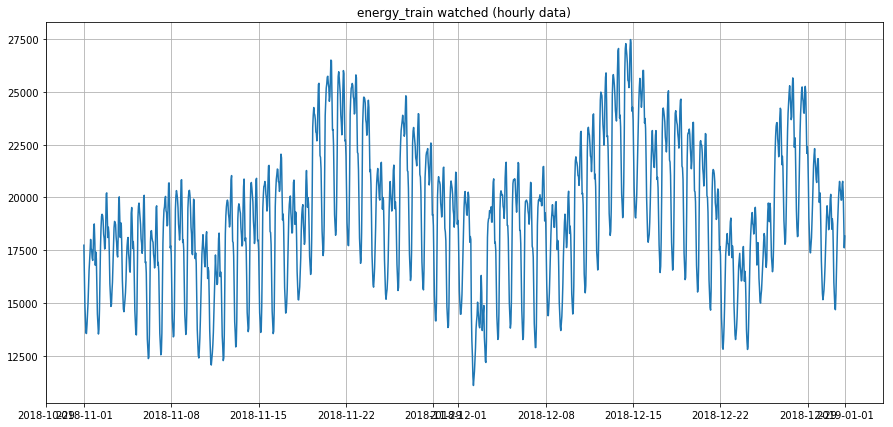

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(energy_train.consommation)
plt.title('energy_train watched (hourly data)')
plt.grid(True)
plt.show()


In [14]:
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [15]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

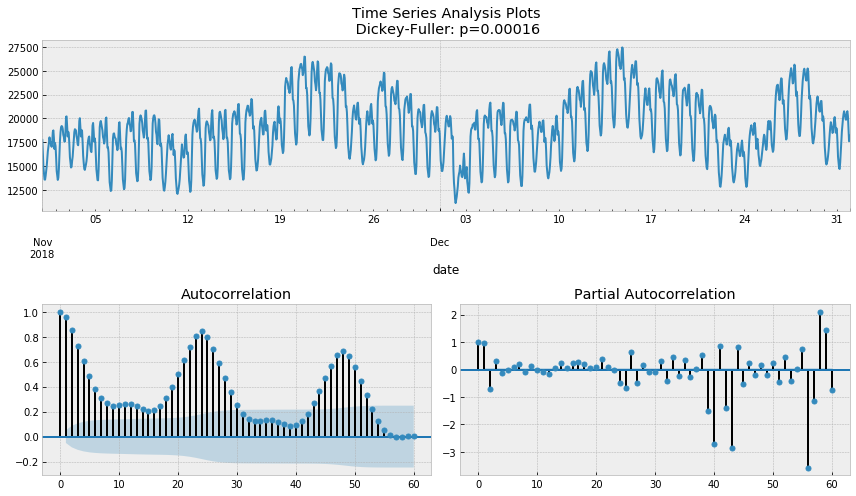

In [16]:
tsplot(energy_train.consommation, lags=60)


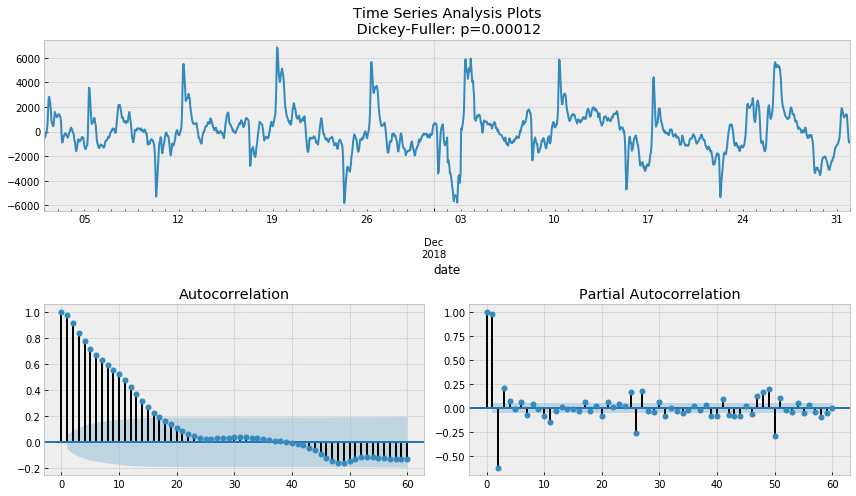

In [17]:
energy_diff = energy_train.consommation -energy_train.consommation.shift(24)
tsplot(energy_diff[24:], lags=60)

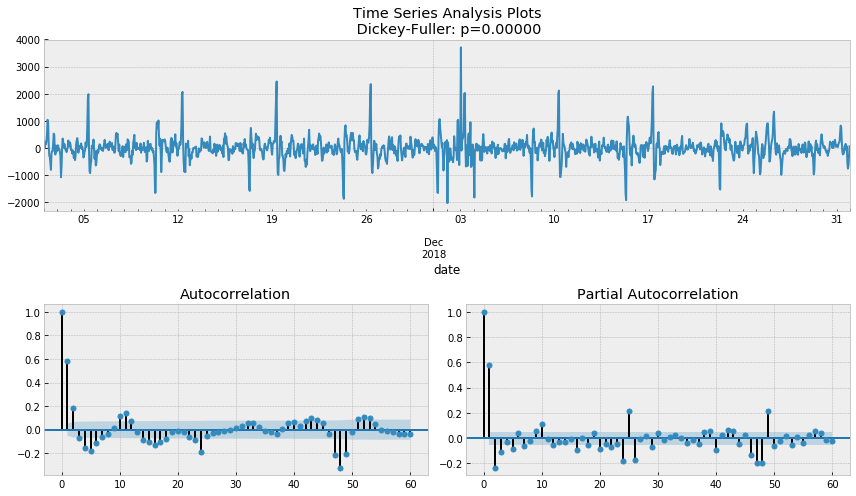

In [18]:
energy_diff = energy_diff - energy_diff.shift(1)
tsplot(energy_diff[24+1:], lags=60)

In [19]:

ps = range(1, 5)
d=1 
qs = range(1, 5)
Ps = range(1, 3)
D=1 
Qs = range(1, 3)
s =24 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [20]:
def optimizeARIMA(parameters_list, d, D, s): 
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(energy_train.consommation, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [21]:
%%time
result_table = optimizeARIMA(parameters_list, d, D, s)



CPU times: user 11h 56min 55s, sys: 23min 19s, total: 12h 20min 15s
Wall time: 3h 28min 10s


In [22]:
result_table.head()

,parameters,aic
0,"(2, 1, 2, 2)",20176.297697
1,"(2, 2, 2, 2)",20177.935071
2,"(4, 1, 2, 2)",20179.208198
3,"(3, 1, 2, 2)",20204.848335
4,"(1, 3, 2, 2)",20213.446706


In [23]:
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(energy_train.consommation, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                       consommation   No. Observations:                 1464
Model:             SARIMAX(2, 1, 1)x(2, 1, 2, 24)   Log Likelihood              -10080.149
Date:                            Wed, 27 Nov 2019   AIC                          20176.298
Time:                                    09:00:25   BIC                          20218.471
Sample:                                11-01-2018   HQIC                         20192.042
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2384      0.064     19.214      0.000       1.112       1.365
ar.L2         -0.5253      0.037   

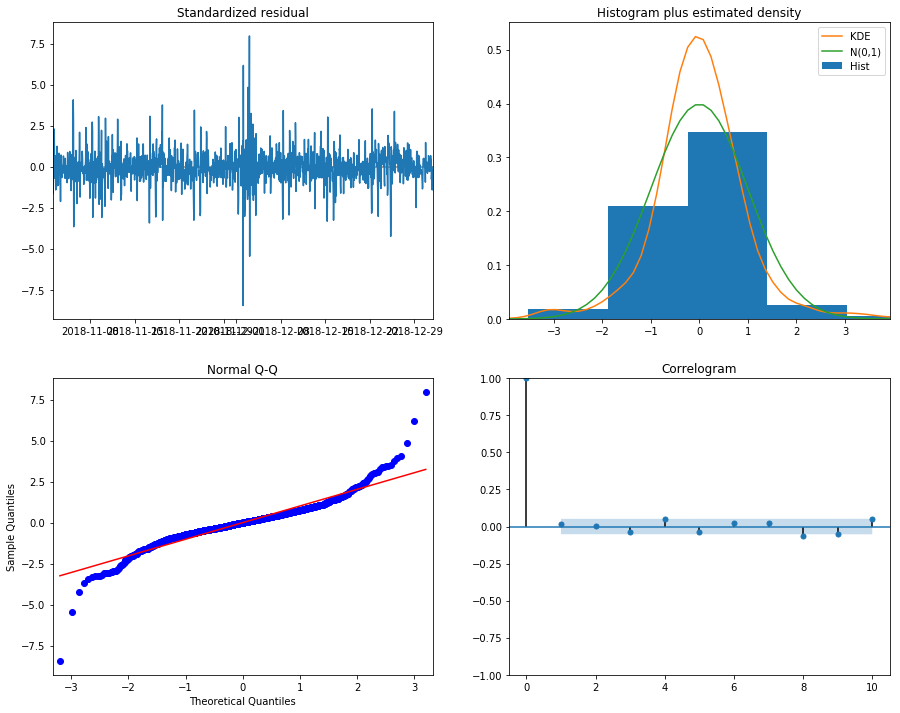

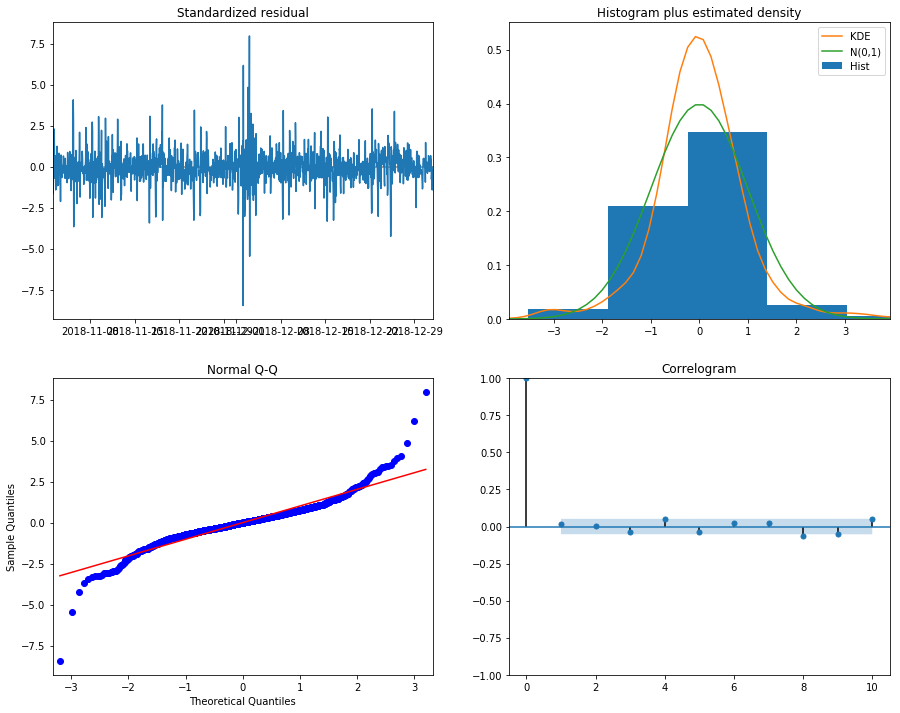

In [24]:
best_model.plot_diagnostics(figsize=(15, 12))

In [25]:
import matplotlib

In [103]:
def plotARIMA(serie_test,series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    #forecast, conf_int = model.forecast(steps=n_steps)
    
    
    pred_uc = model.get_forecast(steps=336)

    pred_ci = pred_uc.conf_int(alpha=0.1)
    print(pred_ci)
    
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    forcast_compare = forecast['2019-01-01 00:00:00':'2019-01-03 23:00:00']
    y_true = serie_test.consommation['2019-01-01 00:00:00':'2019-01-03 23:00:00']
    #print('forcast_compare',forcast_compare)
    #print('serie_test.consommation',serie_test.consommation)
    error = np.mean(np.abs((serie_test.consommation - forcast_compare) / serie_test.consommation)) * 100
     
    matplotlib.rcParams.update({'font.size': 22})
    

    plt.figure(figsize=(10, 5),linewidth=2)
    plt.title("SARIMA: Prediction for Ile de France with MAPE: {0:.2f}%".format(error))
    plt.plot(data.actual[-336:], color='steelblue',label='observation',linewidth=2.0)
    plt.plot(forecast[-336:], color='g', label="forecasting",linewidth=2.0)
    #plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.3, color='lightgrey')
    plt.fill_between(pred_ci.index,pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='green', alpha=.2,label='90% confidence interval' )
 
    plt.plot(serie_test.consommation, color='steelblue', label='_nolegend_')
    plt.grid(which='both')
    plt.ylim([12000, 28000])
    plt.ylabel("consumption (MW)")
    plt.legend(loc=2)
    plt.margins(0)
    plt.rc('xtick', labelsize=10)  
    plt.rc('ytick', labelsize=10)# fontsize of the axes title
    plt.rc('axes', titlesize=15)
    plt.rc('axes', labelsize=10)
    plt.rc('legend', fontsize=10)
    plt.grid(True);

                     lower consommation  upper consommation
2019-01-01 00:00:00        17658.038189        18511.550129
2019-01-01 01:00:00        16311.591314        17976.426010
2019-01-01 02:00:00        14715.772956        17091.074225
2019-01-01 03:00:00        13974.236730        16906.683381
2019-01-01 04:00:00        13276.305977        16622.628800
2019-01-01 05:00:00        13131.090463        16784.207774
2019-01-01 06:00:00        13720.174108        17611.420349
2019-01-01 07:00:00        14647.853074        18738.786760
2019-01-01 08:00:00        15808.685662        20081.051283
2019-01-01 09:00:00        16687.522130        21134.718626
2019-01-01 10:00:00        17383.261270        22003.974407
2019-01-01 11:00:00        17845.554752        22639.541006
2019-01-01 12:00:00        18143.318064        23109.187529
2019-01-01 13:00:00        18235.928613        23370.524253
2019-01-01 14:00:00        17612.008087        22910.761159
2019-01-01 15:00:00        17308.656405 

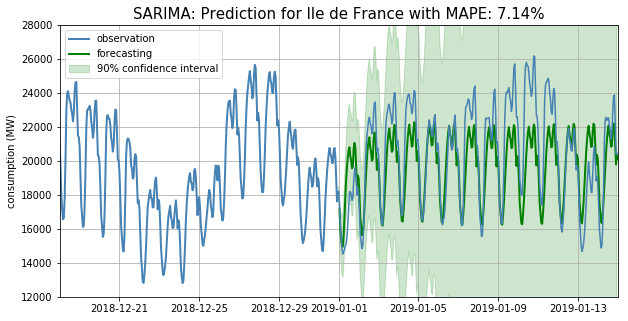

In [102]:
plotARIMA(energy_test,energy_train, best_model, 336)